# COMP0189: Applied Artificial Intelligence

## Week 4 (Linear models, Trees and Ensemble Models )

### After this week you will be able to ...    
    - run various regularized linear models and optimize their regularization parameter in a proper way
    - visualize coefficient of linear models
    - run tree based and emsemble models
    - visualize feature importane for tree based models


   



We will use the Housing dataset for predicting house prices. It includes a variety of features that are commonly believed to influence the price of a house. These features include aspects like the size of the house, the number of bedrooms and bathrooms, location, and other relevant attributes.



### Acknowledgements
- https://scikit-learn.org/stable/
- Harrison, D. and Rubinfeld, D.L. (1978) Hedonic prices and the demand for clean air. J. Environ. Economics and Management 5, 81–102.
Belsley D.A., Kuh, E. and Welsch, R.E. (1980) Regression Diagnostics. Identifying Influential Data and Sources of Collinearity. New York: Wiley.

- https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
interest_rate = 0.04
number_payments = 12
number_years = 30

In [4]:
# define a budget constraint function
def mortage_calculator(annual_income, price, x):
    interest_factor = (1 + (interest_rate / number_payments)) ** (number_years * number_payments)
    payment = price * (interest_rate / number_payments) * (interest_factor / (interest_factor - 1))
    return payment

In [5]:
# test budget constraint function on an user with annual income of 100k on the first housing data
mortage_calculator(100000, df['price'][0], df['bedrooms'][0])

63496.23429690536

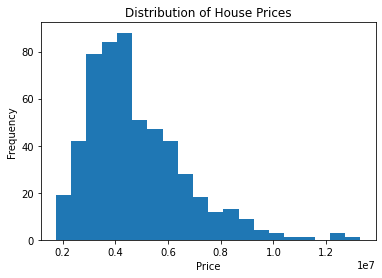

In [6]:
# plot a distribution curve for the house prices
plt.hist(df['price'], bins = 20)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.show()

## Task 1: Create a pipeline for hyper-parameter tuning and model comparison

1.1 Create a pipeline to optize the regularization hyper-paramaters of different linear models (Ridge regression, LASSO and elastic-net) and chose the best model for predicting house prices based on the features provided. Print the average cross-validation performance (with the standard deviation) as well as the test performance.

Linear models: https://scikit-learn.org/stable/modules/linear_model.html#

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import math
import pandas as pd
from scipy.stats import loguniform
import numpy as np
import random

random.seed(0)

# Preprocess the data: Encoding categorical variables
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
numerical_features = df.drop(columns=['price'] + categorical_features).columns.tolist()


# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']), df['price'], test_size=0.2, random_state=0)

binary_categorical_features = ['mainroad', 'guestroom',
                               'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
non_binary_categorical_features = ['furnishingstatus']

# Define the pipeline
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('ordinal', OrdinalEncoder(), binary_categorical_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), non_binary_categorical_features)
])

# apply the preprocessing pipeline to the training data
X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

# Define the parameter grids for each model
ridge_params = {'regressor__alpha': np.logspace(-2, 10, 100)}
lasso_params = {'regressor__alpha': np.logspace(-2, 10, 100)}
elastic_params = {'regressor__alpha': np.logspace(-2, 10, 100), 'regressor__l1_ratio': [0.01, 0.2, 0.5, 0.8]}

# Create a grid search for the optimal parameters for each model and determine the best model.
ridge_grid = GridSearchCV(Pipeline(steps=[('regressor', Ridge())]), ridge_params, scoring='neg_mean_squared_error', cv=5)
lasso_grid = GridSearchCV(Pipeline(steps=[('regressor', Lasso())]), lasso_params, scoring='neg_mean_squared_error', cv=5)
elastic_grid = GridSearchCV(Pipeline(steps=[('regressor', ElasticNet())]), elastic_params, scoring='neg_mean_squared_error', cv=5)

ridge_grid.fit(X_train, y_train)

lasso_grid.fit(X_train, y_train)

elastic_grid.fit(X_train, y_train)

# apply GridSearchCV to the train data
print(ridge_grid.best_params_)

print(lasso_grid.best_params_)

print(elastic_grid.best_params_)

# use GridSearchCV to determine the best model from the optimal parameters
# use GridSearchCV to determine the best model from the optimal parameters
ridge = Pipeline(steps=[('regressor', Ridge(**{k.replace('regressor__', ''): v for k, v in ridge_grid.best_params_.items()}))])

lasso = Pipeline(steps=[('regressor', Lasso(**{k.replace('regressor__', ''): v for k, v in lasso_grid.best_params_.items()}))])

elastic = Pipeline(steps=[('regressor', ElasticNet(**{k.replace('regressor__', ''): v for k, v in elastic_grid.best_params_.items()}))])

# create a pipeline for Gridsearch across ridge, lasso, and elastic net models
models = [ridge, lasso, elastic]

# create a function to calculate the RMSE and R2 scores for each model
def model_scores(models, X_train, y_train, X_test, y_test):
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(model.steps[0][1].__class__.__name__)
        print('RMSE: ', math.sqrt(mean_squared_error(y_test, y_pred)))
        print('R2: ', r2_score(y_test, y_pred))
        print('')

model_scores(models, X_train, y_train, X_test, y_test)

{'regressor__alpha': 2.656087782946687}
{'regressor__alpha': 2848.035868435805}
{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.2}
Ridge
RMSE:  972699.2793508288
R2:  0.671650903374506

Lasso
RMSE:  979312.5738314639
R2:  0.6671708937223337

ElasticNet
RMSE:  969147.9832704817
R2:  0.674044112150362



1.2 Create a plot to show the performance of the different models during hyper-parameter optimization (i.e. the figure should show for each model how the performance varies for the different hyper-parameter value)

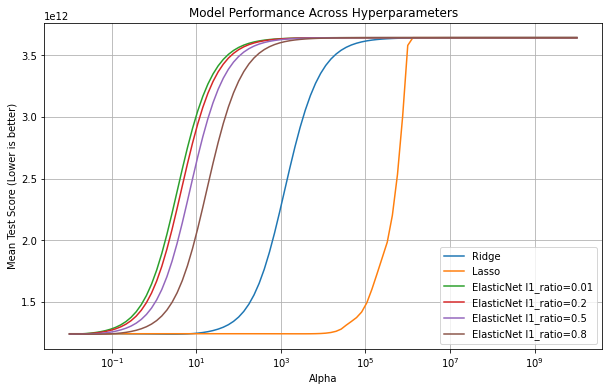

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

def plot_model_performance(grid_search, model_name, ax):
    results = pd.DataFrame(grid_search.cv_results_)
    if model_name != 'ElasticNet':
        # For Ridge and Lasso
        alphas = results['param_regressor__alpha']
        scores = -results['mean_test_score']  # Negate to get MSE
        ax.semilogx(alphas, scores, label=model_name, linestyle='-')

    else:
        # For ElasticNet, need to handle combinations of alpha and l1_ratio
        alphas = results['param_regressor__alpha']
        l1_ratios = results['param_regressor__l1_ratio']
        scores = -results['mean_test_score']  # Negate to get MSE

        # Unique l1_ratios for plotting
        unique_l1_ratios = np.unique(l1_ratios)
        for l1_ratio in unique_l1_ratios:
            # Filter scores for each l1_ratio
            indices = l1_ratios == l1_ratio
            ax.semilogx(alphas[indices], scores[indices], label=f'ElasticNet l1_ratio={l1_ratio}', linestyle='-')

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

grid_search_ridge = GridSearchCV(Pipeline(steps=[('regressor', Ridge())]), ridge_params, scoring='neg_mean_squared_error', cv=5)
grid_search_lasso = GridSearchCV(Pipeline(steps=[('regressor', Lasso())]), lasso_params, scoring='neg_mean_squared_error', cv=5)
grid_search_elastic = GridSearchCV(Pipeline(steps=[('regressor', ElasticNet())]), elastic_params, scoring='neg_mean_squared_error', cv=5)

grid_search_ridge.fit(X_train, y_train)

grid_search_lasso.fit(X_train, y_train)

grid_search_elastic.fit(X_train, y_train)

# Plot the performance of each model on the same axis
plot_model_performance(grid_search_ridge, 'Ridge', ax)
plot_model_performance(grid_search_lasso, 'Lasso', ax)
plot_model_performance(grid_search_elastic, 'ElasticNet', ax)

# Set labels, title, legend, and grid for the plot
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Test Score (Lower is better)')
ax.set_title('Model Performance Across Hyperparameters')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()


1.3 Create figures to show the models coefficients for model interpretation (i.e. including the feature names).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Function to plot model coefficients
def plot_model_coefficients(model, model_name, numerical_features, categorical_features):
    # Extract coefficients
    coefs = model.named_steps['regressor'].coef_

    # Get feature names from the preprocessor
    # For one-hot encoded features, get the feature names from the encoder
    feature_names = []

    # For numerical features, just use the feature names
    feature_names.extend(numerical_features)

    feature_names.extend(binary_categorical_features)

    feature_names.extend(non_binary_categorical_features)

    # Sort the coefficients and corresponding feature names
    sorted_indices = np.argsort(coefs)

    sorted_coefs = coefs[sorted_indices]

    sorted_feature_names = np.array(feature_names)[sorted_indices]

    # Plot
    plt.figure(figsize=(10, 6))

    plt.barh(sorted_feature_names, sorted_coefs)

    plt.xlabel('Coefficient Value')

    plt.title(f'{model_name} Coefficients')

    plt.show()

# Extract best models
best_ridge = grid_search_ridge.best_estimator_
best_lasso = grid_search_lasso.best_estimator_
best_elastic = grid_search_elastic.best_estimator_

# Assume best_ridge, best_lasso, best_elastic are already defined and are the best estimators from GridSearchCV
plot_model_coefficients(best_ridge, "Ridge", numerical_features, categorical_features)
plot_model_coefficients(best_lasso, "Lasso", numerical_features, categorical_features)
plot_model_coefficients(best_elastic, "ElasticNet", numerical_features, categorical_features)



1.4 Create a similarity matrix to show the similarity of the coefficents across the different models

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract coefficients


# Form a matrix of coefficients

# Calculate similarity matrix

# Convert the matrix to a DataFrame for better readability

# Plotting the similarity matrix




### Discussion: How does the performance compare across models? Are the coefficients similar across models?

## Task 2: Create an example of wrong pipeline for task 1.1 and the average CV as well as the test performance.

**Discussion**  
**Did the model performance changed when using a wrong pipeline?**

## Task 3: Tree and ensemble models

3.1 For the same dataset compare the performance of a decision tree and ensemble methods (bagging, boosting and gradient boosting) on predicting the house prices. Compute the feature importance for the different models. Create a table/plots to show the performance of the different models.

Trees: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree  
Ensembles: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor


In [ ]:
from sklearn.pipeline import Pipeline

# Initialize models with a pipeline
decision_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0))
])


# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Model','Test RMSE', 'Test R2'])


# Fit and evaluate models

    # Train the model using the training data


    # Predict on test data

    # Calculate RMSE and R-squared






Decision Tree - Test RMSE: 1457825.542, Test R-squared: 0.262
Bagging - Test RMSE: 1119007.196, Test R-squared: 0.565


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Boosting - Test RMSE: 1012366.657, Test R-squared: 0.644
Gradient Boosting - Test RMSE: 1095379.392, Test R-squared: 0.584


,Model,Test RMSE,Test R2
0,Decision Tree,1.457826e+06,0.262453
1,Bagging,1.119007e+06,0.565445
2,Boosting,1.012367e+06,0.644324
3,Gradient Boosting,1.095379e+06,0.583603


3.2 Create figures to show the feature importance for the different models

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names after preprocessing

def plot_feature_importances(model, name, feature_names, ax):
    # Extract the regressor from the pipeline


    # Handle BaggingRegressor and get feature importances


    # Adjust the feature names if their number doesn't match the importances length

        # Handle transformed feature names

    # Plot feature importances


# Plotting feature importances for each model
#fig, axs = plt.subplots(len(models), figsize=(10, 5 * len(models)))
#for ax, (name, model) in zip(axs, models.items()):
#    plot_feature_importances(model, name, feature_names, ax)

#plt.tight_layout()
#plt.show()

**Discussion**  
**Were the features selected similar across the different models?**

3.3 Compare two different approaches for prunning a decision tree (cost-complexity prunning and max leaves nodes) and plot the resulting trees.

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math

# First, fit the preprocessor on X_train
#preprocessor.fit(X_train)
#X_train_preprocessed = preprocessor.transform(X_train)

# Train a decision tree with cost-complexity pruning


# Train a decision tree with max leaf nodes


# Plot the trees
#plt.figure(figsize=(20, 10))
#plt.subplot(1, 2, 1)
#plot_tree(dt_ccp_pipeline.named_steps['regressor'], filled=True, feature_names=feature_names, rounded=True)
#plt.title('Decision Tree with Cost-Complexity Pruning')

#plt.subplot(1, 2, 2)
#plot_tree(dt_max_leaf_pipeline.named_steps['regressor'], filled=True, feature_names=feature_names, rounded=True)
#plt.title('Decision Tree with Max Leaf Nodes')

#plt.show()

# Evaluate the models
#for name, model, in [("Cost Complexity Pruning", dt_ccp_pipeline), ("Max Leaf Nodes", dt_max_leaf_pipeline)]:
#    y_pred = model.predict(X_test)
#    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
#    r2 = r2_score(y_test, y_pred)
 #   results_df.loc[len(results_df)] = [name, rmse, r2]

#    print(f"{name} - Test RMSE: {rmse:.3f}, Test R-squared: {r2:.3f}")
#results_df

In [ ]:
results_df